# PyScanCf workflow
- Author: Syed Hamid (hamidsyed37[at]gmail.com)
- Date: Jan 17, 2023

1. Make sure you have [Miniconda](https://docs.conda.io/en/latest/miniconda.html) (_recommended_) or [Anaconda](https://www.anaconda.com/) installed.
2. After that open your terminal/command prompt and create a conda environment e.g., `pcf`
> `conda create -n pcf python=3.9 jupyter arm_pyart xarray wradlib git rioxarray -c conda-forge`
3. Once the operation is complete, activate the environment `conda activate pcf`
4. Install PyScanCf using:
> `pip install git+https://github.com/syedhamidali/PyScanCf.git`
5. Launch the jupyter notebook `jupyter-notebook`.

In [1]:
# Installing PyScanCf **Please note that run this cell only once by removing hashtag .
#!pip install git+https://github.com/syedhamidali/PyScanCf.git

In [2]:
import xarray as xr
import pyart
import matplotlib.pyplot as plt
import rioxarray as rio
import pyscancf as pcf
import warnings
warnings.filterwarnings("ignore")


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## Data Conversion
Merging IMD Goa DWR data and converting it to Cf-radial

In [3]:
# Lets define data input and output directory
in_dir = "goa_data/imd_raw/"
out_dir = "goa_data/cfrad_grid/"

In [4]:
pcf.cfrad(input_dir=in_dir, output_dir=out_dir, dualpol=False)

Number of files:  10
Total number of files will be created:  1
Merging all scans in one file
Data merging done 
Total Time Elapsed:  0:00:00.851787


---
# Gridding Data
We have merged and converted the data to cfradial, now lets create it gridded using `pyart` or `PyScanCf`

In [5]:
radar = pyart.io.read("goa_data/cfrad_grid/polar_GOA210516024101-IMD-B.nc")

In [6]:
grid = pcf.get_grid(radar, grid_shape=(1, 500, 500), height=2, length=250)

In [7]:
xg = grid.to_xarray()

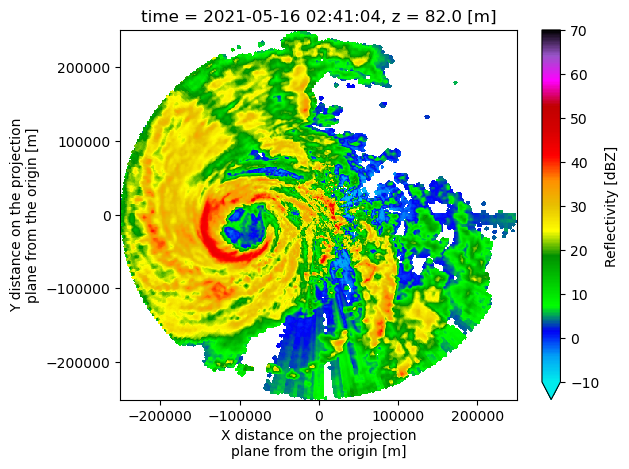

In [8]:
xg.REF[0,0].plot(vmin = -10, vmax = 70, cmap = "pyart_NWSRef")

## Estimate rain rate

1. Convert to reflectivity factor Z (unit: $mm^6/m^3$):
2. Convert to rainfall rate (unit: mm/h) using the Marshall-Palmer Z(R) relation:

In [9]:
def rain_rate(dbz, a=200.0, b=1.6):
    """Calculates the inverse of input decibel values
    Convert to rain rate using Marshall Palmer Relation
    """
    Z = 10.0 ** (dbz / 10.0)
    return  (Z / a) ** (1.0 / b)

In [10]:
R = rain_rate(xg.REF, a=200.0, b=1.6)

In [11]:
R.attrs['units'] = "mm/h"

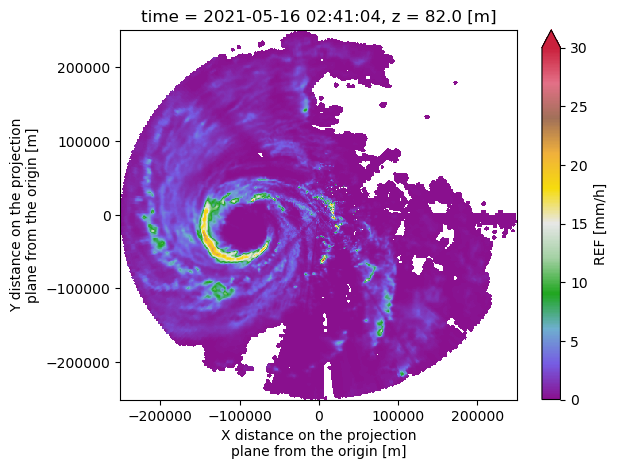

In [12]:
R.plot(vmin = 0, vmax = 30, cmap = pyart.graph.cm.Carbone11)

In [13]:
import cartopy.crs as ccrs
import cartopy.feature as feat
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [14]:
def add_map(ax, b = 0, t=0, l = 0, r = 0):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.3, color='black', alpha=0.3, 
                         linestyle='-', draw_labels=True)
    gl.xlabels_top = t
    gl.xlabels_bottom = b
    gl.ylabels_left = l
    gl.ylabels_right=r
    gl.xlines = True
    gl.ylines = True
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.add_feature(feat.BORDERS, lw = 0.5)
    ax.add_feature(feat.COASTLINE, lw = 0.5)
    ax.add_feature(feat.STATES.with_scale("10m"), alpha = 0.5, lw = 0.5)

In [15]:
R_geo = R.swap_dims({"y":"lat", "x":"lon"})

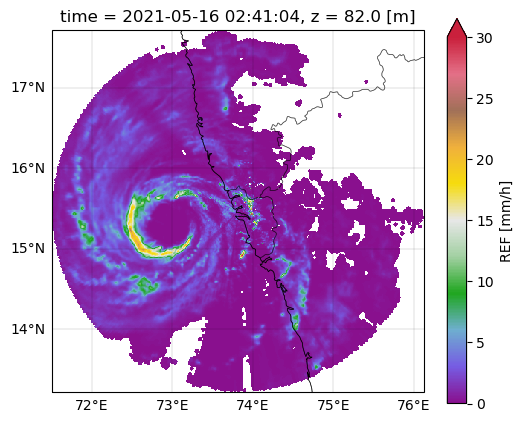

In [16]:
fig = plt.figure(figsize = [6,5])
ax = plt.axes(projection=ccrs.PlateCarree())
R_geo.plot(vmin = 0, vmax = 30, cmap = pyart.graph.cm.Carbone11, ax=ax)
add_map(ax=ax, b = 1, l=1)

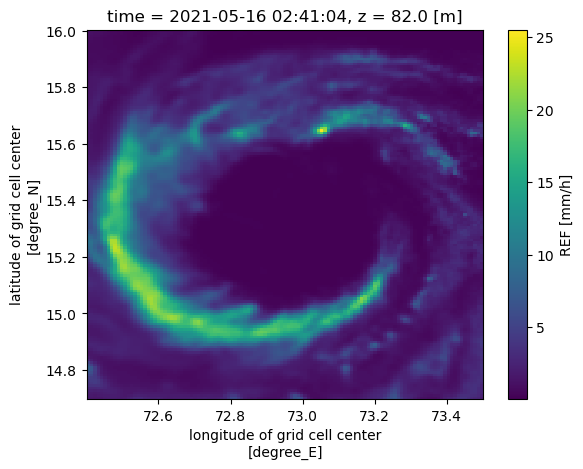

In [17]:
R_geo.sel(lat = slice(14.7, 16), lon = slice(72.4, 73.5)).isel(time=0, z=0).plot()

## Save to GeoTiff file

In [18]:
R_geo[0,0].rio.to_raster("goa_data/cfrad_grid/rainrate.tif")

In [19]:
ls "goa_data/cfrad_grid/"

polar_GOA210516024101-IMD-B.nc  rainrate.tif


In [20]:
Rgx = xr.open_rasterio("goa_data/cfrad_grid/rainrate.tif")

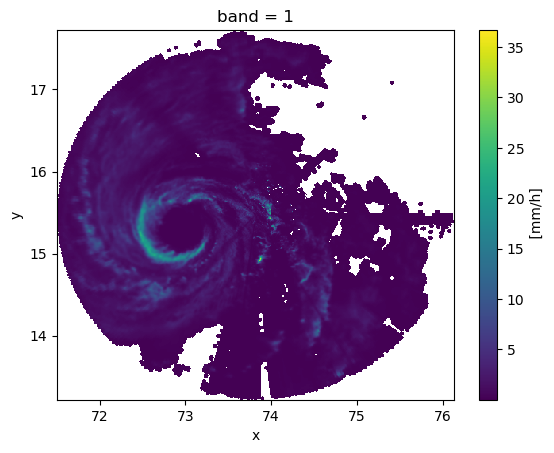

In [21]:
Rgx[0].plot()